In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, DiffusionPipeline
import torch
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from datasets_local.metadata import subset_csv
import pandas as pd
from PIL import Image, ImageDraw

In [2]:
# define model and load weights
model_dir='Likalto4/mammo_lesion-inpainting'
pipe = DiffusionPipeline.from_pretrained(
    model_dir,
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")
generator = torch.Generator(device='cuda')
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()

text_encoder/model.safetensors not found
/home/ricardo/miniconda3/envs/dreambooth_light/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/2

This notebook is to create synthetic images using an inpainting model. 

# Old way of creating bbox: coordinates

In [3]:
### Metadata and paths preparation ###
# define folder of input images
input_images_name = 'breast40k_RGB_healthy'
input_images_folder_path = repo_path / 'data/images' / input_images_name
reference_folder_path = repo_path / 'data/metadata/metadata_Hologic.csv'

# define matadata path and create file if needed
metadata_path = subset_csv(input_images_folder_path, reference_folder_path) # get metadata csv of the subset
# read metadata
metadata = pd.read_csv(metadata_path, header=0)

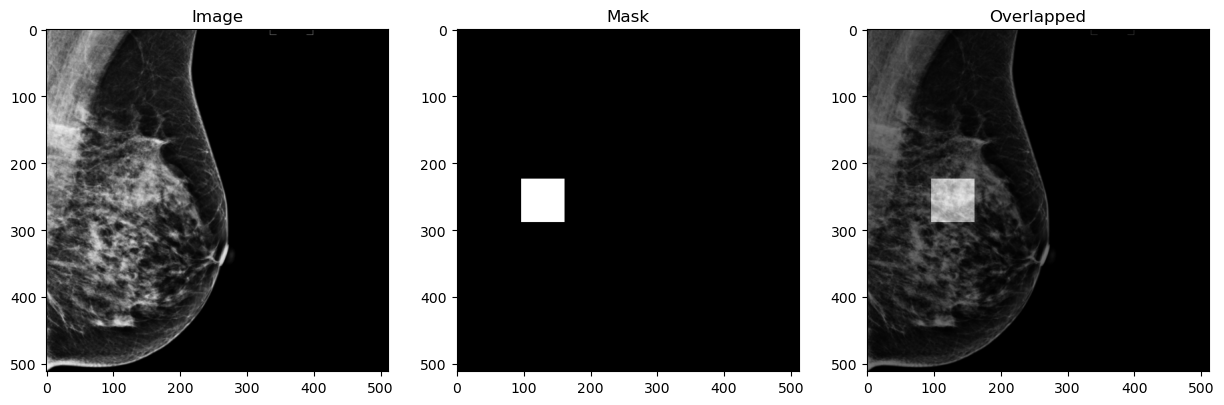

In [4]:
# get image
im_num = 5
# get one image example
image_id = metadata.iloc[im_num]['image_id']
image_file = image_id + '.png'
image_path = input_images_folder_path / image_file
# read image using pil
input_im = Image.open(image_path)
# create mask
mask = Image.new(mode='L',size=input_im.size, color=0)
draw = ImageDraw.Draw(mask)
center = (input_im.size[0] // 4, input_im.size[1] // 2)
size = (input_im.size[0] // 8, input_im.size[1] // 8)
draw.rectangle(
            (center[0] - size[0] // 2, center[1] - size[1] // 2, center[0] + size[0] // 2, center[1] + size[1] // 2),
            fill=255,
        )
# show image and mask
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(input_im)
ax[0].set_title('Image')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(input_im)
ax[2].imshow(mask, cmap='gray', alpha=0.5)
ax[2].set_title('Overlapped')
# save all 3 images
# experiment path
exp_path = repo_path / 'experiments/inference'
input_im.save(exp_path / 'data/inpainting/input_images'/f'{image_id}.png')
mask.save(exp_path / 'data/inpainting/custom_masks'/f'{image_id}.png')

# convert pil image to L mode
input_im = input_im.convert("L")
# save overklapping image
overlapped = Image.blend(input_im, mask, 0.5)
overlapped.save(exp_path / 'data/inpainting/overlapped'/f'{image_id}.png')

  0%|          | 0/24 [00:00<?, ?it/s]

[None, None, None, None]

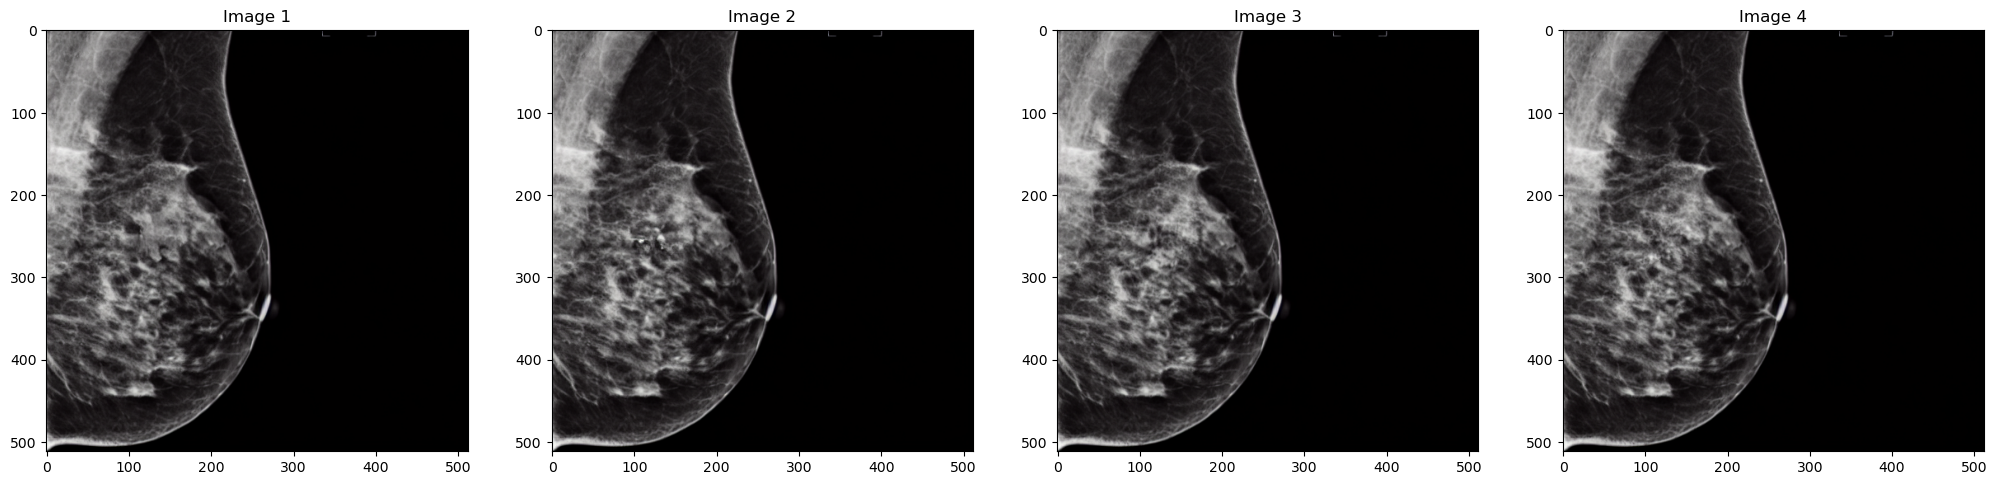

In [5]:
### generate images ###

#HP
guidance_scale = 3
prompt = "a mammogram with a lesion"
seed = 1337
generator.manual_seed(seed)
negative_prompt = ""
num_samples = 4
num_inference_steps = 24
size = 512
with torch.autocast("cuda"), torch.inference_mode():
    image = pipe(
        prompt=prompt,
        image=input_im,
        mask_image=mask,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        height=size,
        width=size,
        generator=generator,
    ).images

# show images
fig, ax = plt.subplots(1,4, figsize=(25,10))
for i in range(4):
    ax[i].imshow(image[i], cmap='gray')
    ax[i].set_title(f'Image {i+1}')
# save generated images
[im.save(exp_path / 'data/inpainting/generated'/f'{image_id}_{i}.png') for i, im in enumerate(image)]

# Gradio UI

In [29]:
import gradio as gr
from gradio import Interface
from PIL import Image, ImageColor, ImageChops


### Metadata and paths preparation ###
# define folder of input images
input_images_name = 'breast40k_RGB_healthy'
input_images_folder_path = repo_path / 'data/images' / input_images_name
reference_folder_path = repo_path / 'data/metadata/metadata_Hologic.csv'
# define matadata path and create file if needed
metadata_path = subset_csv(input_images_folder_path, reference_folder_path) # get metadata csv of the subset
# read metadata
metadata = pd.read_csv(metadata_path, header=0)

### get input image ###
im_num = 5
# get one image example
image_id = metadata.iloc[im_num]['image_id']
image_file = image_id + '.png'
image_path = input_images_folder_path / image_file
# read image using pil
input_im = Image.open(image_path)


### fn function ###

# sketchpad with breast image as background
sketchpad = gr.Sketchpad(shape=(512, 512), invert_colors=True, type='pil', )
sketch = gr.Image(value=input_im, type='pil', interactive=True, tool='sketch', invert_colors=True, image_mode='L')

def fn(sketch):
    # get mask from input sketch
    mask = sketch['mask']

    ### generate images ###
    #HP
    guidance_scale = 3
    prompt = "a mammogram with a lesion"
    seed = 1337
    generator.manual_seed(seed)
    negative_prompt = ""
    num_samples = 1
    num_inference_steps = 24
    size = 512
    with torch.autocast("cuda"), torch.inference_mode():
        image = pipe(
            prompt=prompt,
            image=input_im,
            mask_image=mask, # mask coming from the sketchpad
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_samples,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            height=size,
            width=size,
            generator=generator,
        ).images


    return image[0]

# define the interface
iface = Interface(
    fn=fn,
    inputs=sketch,
    outputs="image",
    title="MAM-E drawing tool",
    description="Draw a lesion",
)

iface.launch(debug=True, share=False)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
